# Heart disease prediction with PysparkML

# 1️⃣ Chargement et préparation des données

## Télécharger le dataset

In [65]:
# import pyspark
# from google.colab import files
# uploaded = files.upload()

## Importations necessaires

In [66]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, mean, stddev, min, max
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Création d'un session Pyspark

In [67]:
spark= SparkSession.builder \
.appName("Heart Disease Prediction") \
.config("spark.some.config.option", "some-value") \
.getOrCreate()
print(" Spark Session créée avec succès")
print(f"Version Spark: {spark.version}")

 Spark Session créée avec succès
Version Spark: 3.5.1


## Chargement des données dans un data frame Pyspark

In [68]:
csv_path = "/content/heart-disease-68ec37d6b52cb588200595.csv"
df_raw = spark.read.csv(csv_path, header=True, inferSchema=True)
print(f"\n Dimensions du dataset: {df_raw.count()} lignes, et {len(df_raw.columns)} colonnes")
print("\n Aperçu des colonnes:")
df_raw.printSchema()


 Dimensions du dataset: 303 lignes, et 15 colonnes

 Aperçu des colonnes:
root
 |-- ID: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Sex: double (nullable = true)
 |-- Angina: double (nullable = true)
 |-- Blood_Pressure: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Glycemia: double (nullable = true)
 |-- ECG: double (nullable = true)
 |-- Heart_Rate: double (nullable = true)
 |-- Angina_After_Sport: double (nullable = true)
 |-- ECG_Angina: double (nullable = true)
 |-- ECG_Slope: double (nullable = true)
 |-- Fluoroscopy: string (nullable = true)
 |-- Thalassaemia: string (nullable = true)
 |-- Disease: integer (nullable = true)



## Valeurs manquantes

In [69]:
print(" Vérification des valeurs manquantes:")
df_raw.select([count(when(col(c).isNull(), c)).alias(c) for c in df_raw.columns]).show()

 Vérification des valeurs manquantes:
+---+---+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
| ID|Age|Sex|Angina|Blood_Pressure|Cholesterol|Glycemia|ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|Thalassaemia|Disease|
+---+---+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+
|  0|  0|  0|     0|             0|          0|       0|  0|         0|                 0|         0|        0|          0|           0|      0|
+---+---+---+------+--------------+-----------+--------+---+----------+------------------+----------+---------+-----------+------------+-------+



## Recoder certaines valeurs pour la lisibilité

In [70]:
df_raw=df_raw.withColumn("Sex",when(col("Sex")==0,"Female").otherwise("Male"))
df_raw=df_raw.withColumn("Glycemia", when(col("Glycemia")==0,"<=120").otherwise(">120"))
df_raw=df_raw.withColumn("Angina_After_Sport",when(col("Angina_After_Sport")==0,"No").otherwise("Yes"))
df_raw=df_raw.withColumn("Angina",when(col("Angina")==1,"Stable Angina").when(col("Angina")==2,"Unstable angina").when(col("Angina")==3,"Other pains").otherwise("Asymptomatic"))
df_raw=df_raw.withColumn("ECG",when(col("ECG")==0,"Normal").when(col("ECG")=="1","Anomalies").otherwise("Hypertrophy"))
df_raw=df_raw.withColumn("Disease",when(col("Disease")==0,"No").otherwise("Yes"))
df_raw=df_raw.withColumn("ECG_Slope",when(col("ECG_Slope")==1,"Rising").when(col("ECG_Slope")=="2","Stable").otherwise("Falling"))
df_raw=df_raw.withColumn("Fluoroscopy",when(col("Fluoroscopy")==0,"No anomaly").when(col("Fluoroscopy")==1,"Low").when(col("Fluoroscopy")==2,"Medium").otherwise("High"))
df_raw=df_raw.withColumn("Thalassaemia",when(col("Thalassaemia")==3,"No").when(col("Thalassaemia")=="6","Thalassemia under control").otherwise("Unstable Thalassaemia"))
df_raw.show()

+---+----+------+---------------+--------------+-----------+--------+-----------+----------+------------------+----------+---------+-----------+--------------------+-------+
| ID| Age|   Sex|         Angina|Blood_Pressure|Cholesterol|Glycemia|        ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|        Thalassaemia|Disease|
+---+----+------+---------------+--------------+-----------+--------+-----------+----------+------------------+----------+---------+-----------+--------------------+-------+
|  1|63.0|  Male|  Stable Angina|         145.0|      233.0|    >120|Hypertrophy|     150.0|                No|       2.3|  Falling| No anomaly|Unstable Thalassa...|     No|
|  2|67.0|  Male|   Asymptomatic|         160.0|      286.0|   <=120|Hypertrophy|     108.0|               Yes|       1.5|   Stable|       High|                  No|    Yes|
|  3|67.0|  Male|   Asymptomatic|         120.0|      229.0|   <=120|Hypertrophy|     129.0|               Yes|       2.6|   Stabl

# 2️⃣ Analyse exploratoire des données

## Statistiques descriptives sur les variables numériques.

In [71]:
numerical_cols=["Age","Blood_Pressure","Cholesterol","Heart_Rate","ECG_Angina"]
df_raw.describe(numerical_cols).show()

+-------+-----------------+------------------+------------------+------------------+------------------+
|summary|              Age|    Blood_Pressure|       Cholesterol|        Heart_Rate|        ECG_Angina|
+-------+-----------------+------------------+------------------+------------------+------------------+
|  count|              303|               303|               303|               303|               303|
|   mean|54.43894389438944|131.68976897689768|246.69306930693068| 149.6072607260726|1.0396039603960396|
| stddev| 9.03866244244675| 17.59974772958769|51.776917542637065|22.875003276980383| 1.161075022068635|
|    min|             29.0|              94.0|             126.0|              71.0|               0.0|
|    max|             77.0|             200.0|             564.0|             202.0|               6.2|
+-------+-----------------+------------------+------------------+------------------+------------------+



## Statistiques descriptives sur les variables catégorielles.

In [72]:
categorical_cols = ["Sex", "Angina", "Glycemia", "ECG", "ECG_Slope", "Fluoroscopy", "Thalassaemia"]
for c in categorical_cols:
    print(f"--- Distribution de {c} ---")
    df_raw.groupBy(c).count().orderBy("count", ascending=False).show()

--- Distribution de Sex ---
+------+-----+
|   Sex|count|
+------+-----+
|  Male|  206|
|Female|   97|
+------+-----+

--- Distribution de Angina ---
+---------------+-----+
|         Angina|count|
+---------------+-----+
|   Asymptomatic|  144|
|    Other pains|   86|
|Unstable angina|   50|
|  Stable Angina|   23|
+---------------+-----+

--- Distribution de Glycemia ---
+--------+-----+
|Glycemia|count|
+--------+-----+
|   <=120|  258|
|    >120|   45|
+--------+-----+

--- Distribution de ECG ---
+-----------+-----+
|        ECG|count|
+-----------+-----+
|     Normal|  151|
|Hypertrophy|  148|
|  Anomalies|    4|
+-----------+-----+

--- Distribution de ECG_Slope ---
+---------+-----+
|ECG_Slope|count|
+---------+-----+
|   Rising|  142|
|   Stable|  140|
|  Falling|   21|
+---------+-----+

--- Distribution de Fluoroscopy ---
+-----------+-----+
|Fluoroscopy|count|
+-----------+-----+
| No anomaly|  176|
|        Low|   65|
|     Medium|   38|
|       High|   24|
+-----------+--

## Vérifier l'équilibre des classes dans la colonne Disease

In [73]:
df_raw.groupBy("Disease").count().orderBy("Disease").show()

+-------+-----+
|Disease|count|
+-------+-----+
|     No|  164|
|    Yes|  139|
+-------+-----+



On remarque que les classes ne sont pas équilibrées.

## Visualisations simples

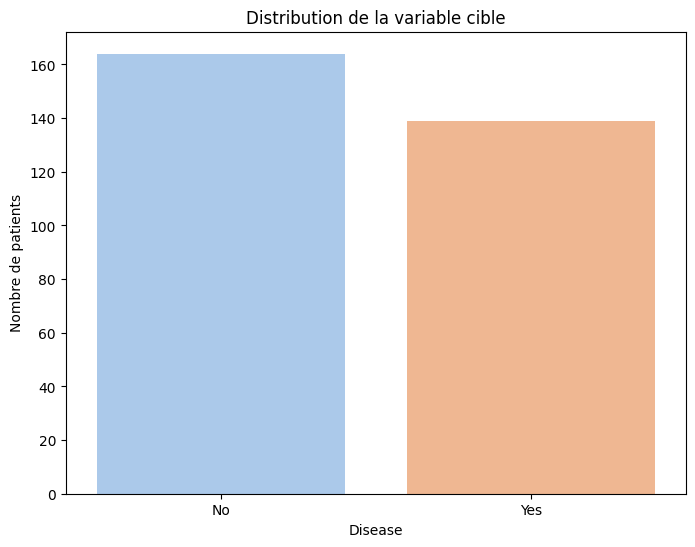

In [74]:
disease_dist = df_raw.groupBy("Disease").count().toPandas()
plt.figure(figsize=(8, 6))
sns.barplot(x="Disease", y="count", data=disease_dist,hue='Disease', palette="pastel")
plt.xlabel("Disease")
plt.ylabel("Nombre de patients")
plt.title("Distribution de la variable cible")
plt.savefig("distribution_disease.png", dpi=300, bbox_inches='tight')
plt.show()

Text(0.5, 1.02, 'Pairplot des variables numériques')

<Figure size 1200x800 with 0 Axes>

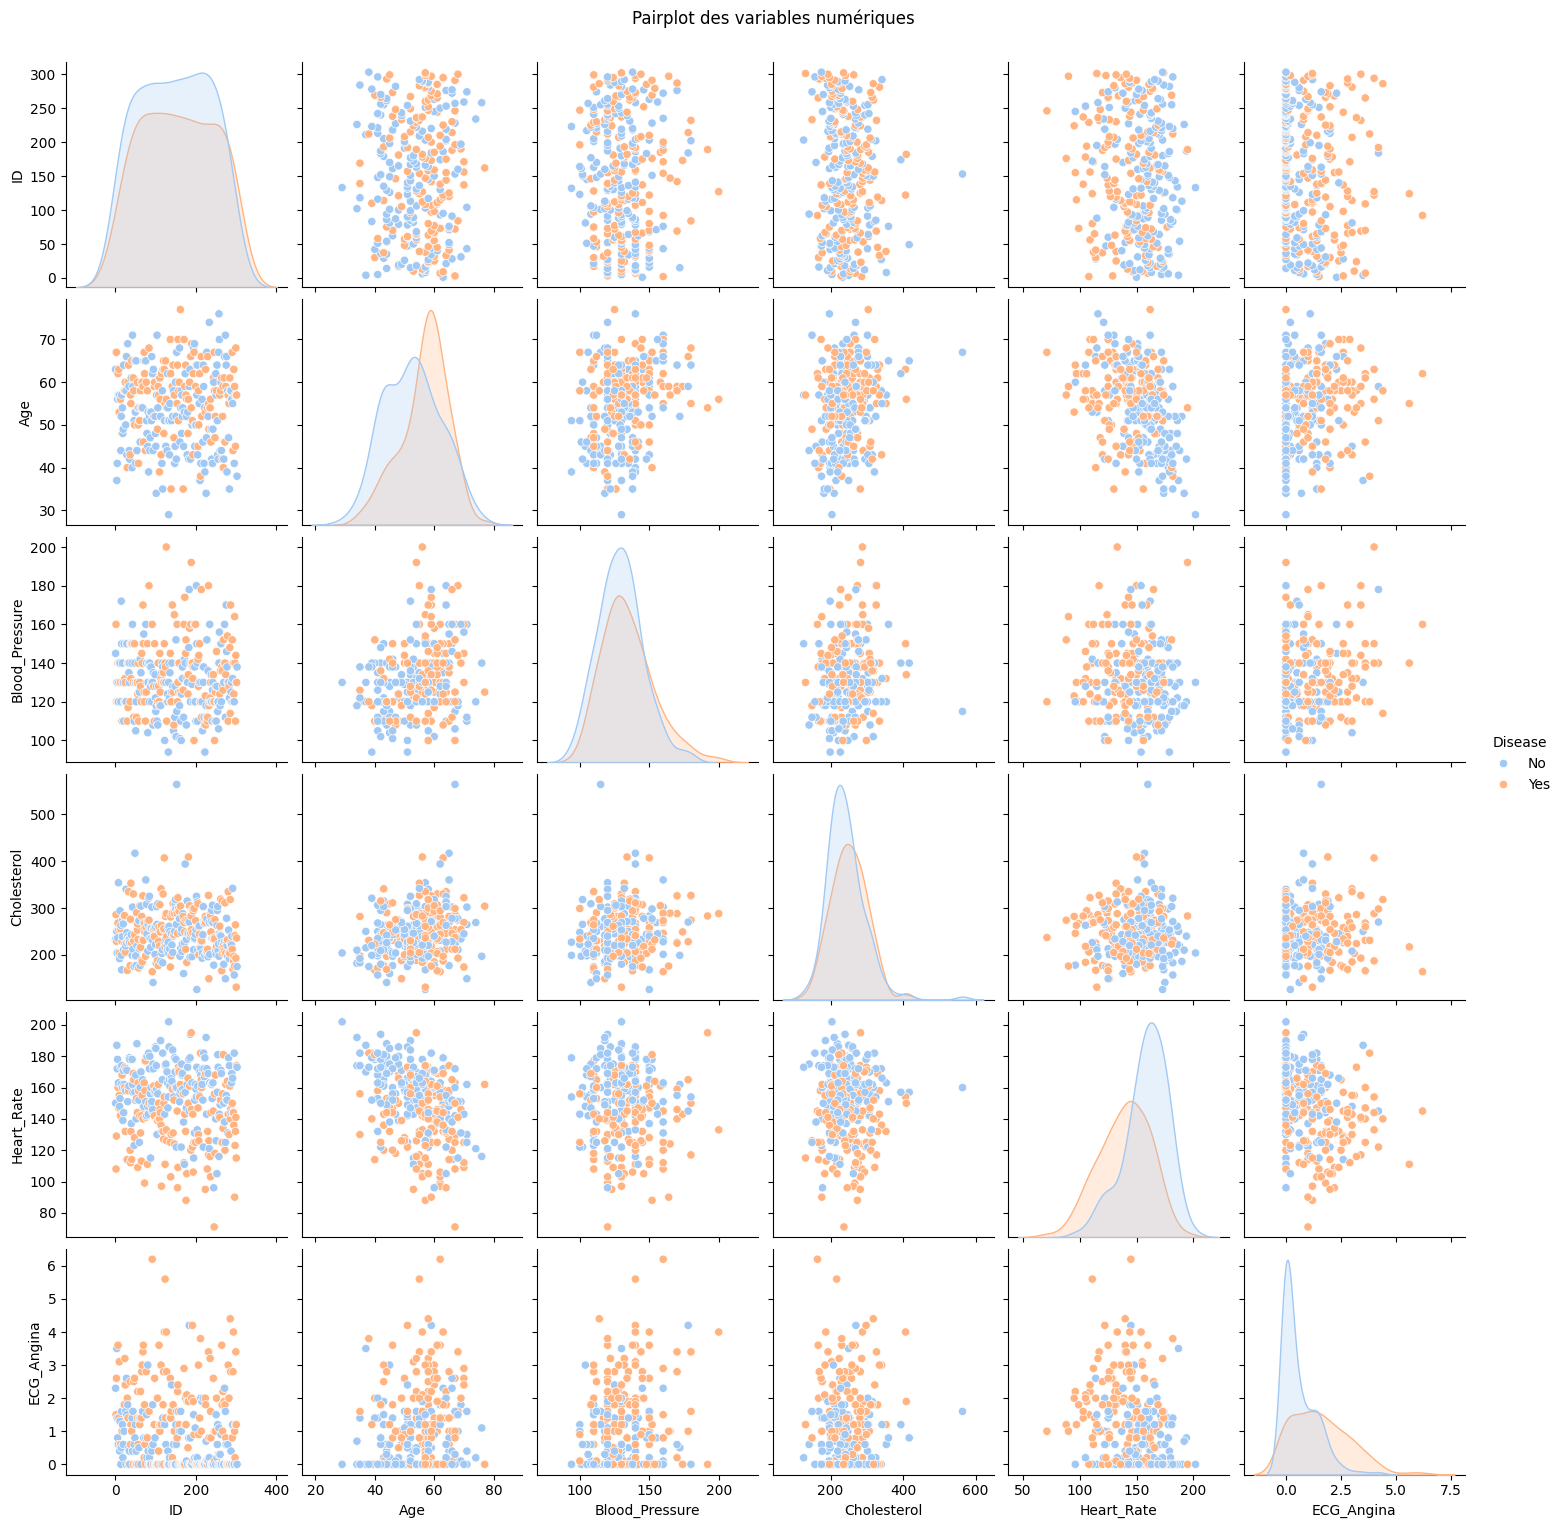

In [75]:

plt.figure(figsize=(12, 8))
sns.pairplot(df_raw.toPandas(), hue="Disease", palette="pastel")
plt.suptitle("Pairplot des variables numériques", y=1.02)

<Axes: xlabel='Age', ylabel='Count'>

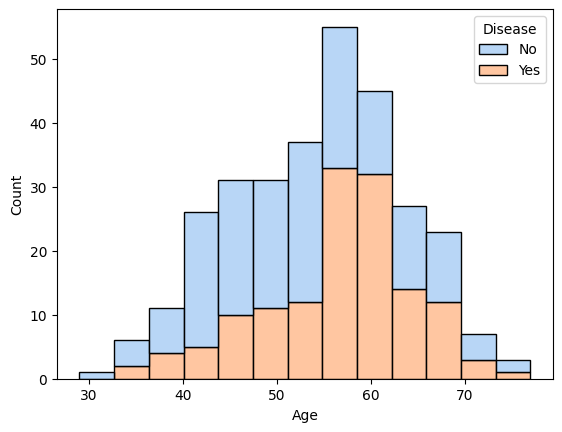

In [76]:
sns.histplot(data=df_raw.toPandas(), x="Age", hue="Disease", multiple="stack", palette="pastel")

<Axes: xlabel='Heart_Rate', ylabel='Count'>

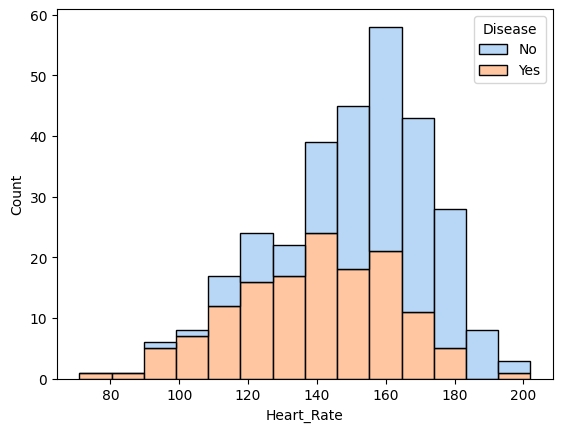

In [77]:
sns.histplot(data=df_raw.toPandas(), x="Heart_Rate", hue="Disease", multiple="stack", palette="pastel")

## Box plots des variables numériques du dataset

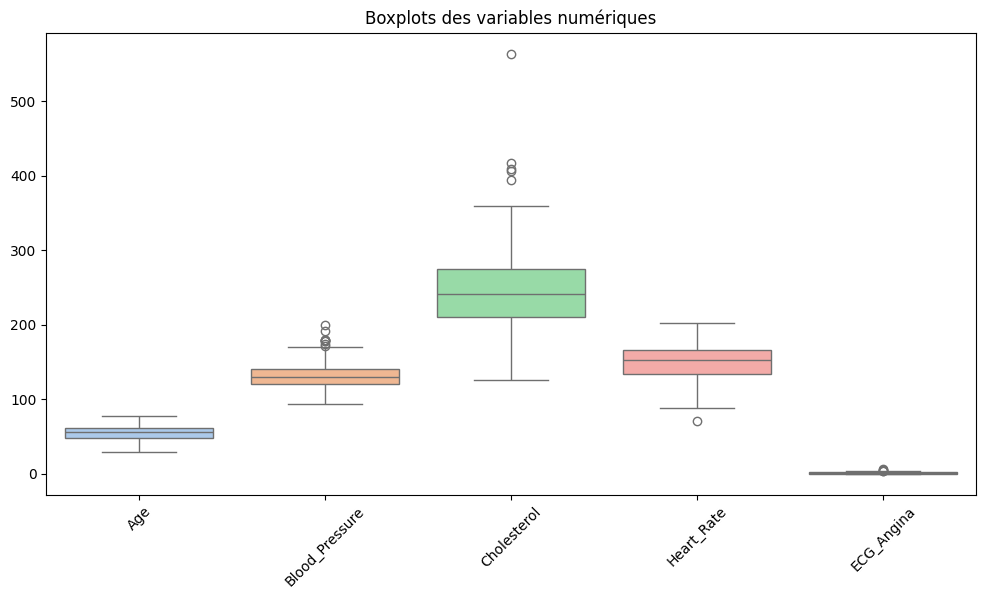

In [78]:
plt.figure(figsize=(12,6))
sns.boxplot(data=df_raw[numerical_cols].toPandas(), palette="pastel")
plt.title("Boxplots des variables numériques")
plt.xticks(rotation=45)
plt.show()

# 3️⃣ Prétraitement avancé

## Feature engineering

In [79]:
df_featured = df_raw.withColumn("Age_BP_Ratio", col("Age") / col("Blood_Pressure"))
df_featured = df_featured.withColumn("BP_Chol_Product", col("Blood_Pressure") * col("Cholesterol") / 10000)
numeric_cols_extended=numerical_cols+["Age_BP_Ratio","BP_Chol_Product"]
print("Aperçu des colonnes après feature engineering:")
df_featured.printSchema()


Aperçu des colonnes après feature engineering:
root
 |-- ID: integer (nullable = true)
 |-- Age: double (nullable = true)
 |-- Sex: string (nullable = false)
 |-- Angina: string (nullable = false)
 |-- Blood_Pressure: double (nullable = true)
 |-- Cholesterol: double (nullable = true)
 |-- Glycemia: string (nullable = false)
 |-- ECG: string (nullable = false)
 |-- Heart_Rate: double (nullable = true)
 |-- Angina_After_Sport: string (nullable = false)
 |-- ECG_Angina: double (nullable = true)
 |-- ECG_Slope: string (nullable = false)
 |-- Fluoroscopy: string (nullable = false)
 |-- Thalassaemia: string (nullable = false)
 |-- Disease: string (nullable = false)
 |-- Age_BP_Ratio: double (nullable = true)
 |-- BP_Chol_Product: double (nullable = true)



## Encodage : StringIndexer et OneHotEncoder pour les variables catégorielles.

StringIndexer pour les variables catégorielles


In [80]:
indexers = [StringIndexer(inputCol=col, outputCol=col+"_indexed", handleInvalid="keep")
            for col in categorical_cols]

One Hot Encoder pour les variables catégorielles

In [81]:
encoder_input_cols = [col+"_indexed" for col in categorical_cols]
encoder_output_cols = [col+"_encoded" for col in categorical_cols]

encoder = OneHotEncoder(inputCols=encoder_input_cols,
                        outputCols=encoder_output_cols,
                        handleInvalid="keep")

VectorAssembler pour combiner toutes les features

In [82]:
assembler_inputs = encoder_output_cols + numeric_cols_extended
assembler = VectorAssembler(inputCols=assembler_inputs,
                            outputCol="features_unscaled",
                            handleInvalid="skip")

StandardScaler pour normaliser les features

In [83]:
scaler = StandardScaler(inputCol="features_unscaled",
                       outputCol="features",
                       withStd=True,
                       withMean=True)

# 4️⃣ Construction du pipeline ML

## Créer le pipeline de prétraitement

In [84]:
preprocessing_stages = indexers + [encoder, assembler, scaler]

print(f"Pipeline de prétraitement créé avec {len(preprocessing_stages)} étapes")


Pipeline de prétraitement créé avec 10 étapes


## Split Train/Test 70/30

In [85]:
# Convert the 'Disease' column to a numeric type using StringIndexer
label_indexer = StringIndexer(inputCol="Disease", outputCol="label").fit(df_featured)
df_indexed = label_indexer.transform(df_featured)

train_data, test_data = df_indexed.randomSplit([0.7, 0.3], seed=42)
print(f"Données d'entraînement: {train_data.count()} lignes")
print(f"Données de test: {test_data.count()} lignes")

Données d'entraînement: 224 lignes
Données de test: 79 lignes


Vérifier la distribution de la cible dans train et test

In [86]:
print("Distribution dans le train set:")
train_data.groupBy("label").count().show()

print("Distribution dans le test set:")
test_data.groupBy("label").count().show()

Distribution dans le train set:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|  118|
|  1.0|  106|
+-----+-----+

Distribution dans le test set:
+-----+-----+
|label|count|
+-----+-----+
|  0.0|   46|
|  1.0|   33|
+-----+-----+



## Modèle Logistic Regression

Créer le modèle

In [87]:
lr = LogisticRegression(featuresCol="features",
                        labelCol="label",
                        maxIter=100,
                        regParam=0.01,
                        elasticNetParam=0.5)

Pipeline complet

In [88]:
# The pipeline now includes the preprocessing stages and the Logistic Regression model
lr_pipeline = Pipeline(stages=preprocessing_stages + [lr])

Entrainement

In [89]:
lr_model = lr_pipeline.fit(train_data)

Prédictions

In [91]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("label", "prediction", "probability").show(10, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|1.0  |1.0       |[0.015655941904799037,0.984344058095201] |
|1.0  |1.0       |[0.12302972549315981,0.8769702745068402] |
|1.0  |1.0       |[0.028271776832393763,0.9717282231676062]|
|1.0  |1.0       |[0.1519892096483127,0.8480107903516874]  |
|0.0  |0.0       |[0.8349120902348294,0.16508790976517063] |
|0.0  |0.0       |[0.7971981280670132,0.20280187193298682] |
|0.0  |0.0       |[0.945502910925119,0.054497089074881044] |
|0.0  |0.0       |[0.9193896436979698,0.08061035630203017] |
|0.0  |0.0       |[0.9612119412914488,0.038788058708551176]|
|1.0  |1.0       |[0.18122608610121563,0.8187739138987844] |
+-----+----------+-----------------------------------------+
only showing top 10 rows



Evaluation

In [92]:
evaluator_acc = MulticlassClassificationEvaluator(labelCol="label",
                                                   predictionCol="prediction",
                                                   metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="label",
                                                  predictionCol="prediction",
                                                  metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="label",
                                                         predictionCol="prediction",
                                                         metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="label",
                                                      predictionCol="prediction",
                                                      metricName="weightedRecall")

lr_accuracy = evaluator_acc.evaluate(lr_predictions)
lr_f1 = evaluator_f1.evaluate(lr_predictions)
lr_precision = evaluator_precision.evaluate(lr_predictions)
lr_recall = evaluator_recall.evaluate(lr_predictions)

print(f"RÉSULTATS LOGISTIC REGRESSION:")
print(f"   Accuracy:  {lr_accuracy:.4f}")
print(f"   F1-Score:  {lr_f1:.4f}")
print(f"   Precision: {lr_precision:.4f}")
print(f"   Recall:    {lr_recall:.4f}")

RÉSULTATS LOGISTIC REGRESSION:
   Accuracy:  0.8734
   F1-Score:  0.8710
   Precision: 0.8795
   Recall:    0.8734


Matrice de confusion

In [93]:
lr_predictions.groupBy("label","prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   25|
|  0.0|       1.0|    2|
|  1.0|       0.0|    8|
|  0.0|       0.0|   44|
+-----+----------+-----+



## Modèle Random Forest

Créer le modèle et le pipeline complet


In [94]:
rf = RandomForestClassifier(featuresCol="features",
                            labelCol="label",
                            numTrees=100,
                            maxDepth=10,
                            seed=42)

Pipeline complet

In [95]:
rf_pipeline=Pipeline(stages=preprocessing_stages+[rf])

Entrainement et prédictions

In [ ]:
rf_model = rf_pipeline.fit(train_data)
rf_predictions = rf_model.transform(test_data)

Evaluation

In [98]:
rf_accuracy = evaluator_acc.evaluate(rf_predictions)
rf_f1 = evaluator_f1.evaluate(rf_predictions)
rf_precision = evaluator_precision.evaluate(rf_predictions)
rf_recall = evaluator_recall.evaluate(rf_predictions)

print(f"RÉSULTATS RANDOM FOREST:")
print(f"   Accuracy:  {rf_accuracy:.4f}")
print(f"   F1-Score:  {rf_f1:.4f}")
print(f"   Precision: {rf_precision:.4f}")
print(f"   Recall:    {rf_recall:.4f}")


RÉSULTATS RANDOM FOREST:
   Accuracy:  0.8354
   F1-Score:  0.8341
   Precision: 0.8353
   Recall:    0.8354


Feature importance

Un pipeline Pyspark (ici rf_model) est une suite d'étapes q'on peut appler **stages**:

 1:Encodage --> 2: Assemblage --> Modèle.

 L'index[-1] signifie la dernière étape.


In [99]:
rf_model_stage = rf_model.stages[-1]

Chaque modèle Random Forest calcule automatiquement l’importance de chaque variable pendant l’entraînement :

Il mesure combien chaque feature réduit l’erreur de prédiction.

Plus une variable contribue souvent à la division des arbres, plus elle est importante.

Le résultat est un vecteur de poids (une importance par feature).

In [100]:
feature_importance = rf_model_stage.featureImportances.toArray()
# Détails de syntaxe :

# rf_model_stage.featureImportances → un objet SparseVector (vecteur creux).

# .toArray() → convertit ce vecteur Spark en array NumPy classique pour pouvoir l’utiliser avec Pandas ou Python.

On crée un tableau Pandas (DataFrame) pour visualiser et manipuler les résultats facilement.

In [103]:
feature_names = assembler_inputs
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance[:len(feature_names)]
}).sort_values('Importance', ascending=False)

print("TOP 10 Features les plus importantes:")
print(importance_df.head(5))

TOP 10 Features les plus importantes:
              Feature  Importance
3         ECG_encoded    0.096912
0         Sex_encoded    0.029449
4   ECG_Slope_encoded    0.028746
1      Angina_encoded    0.020023
11         ECG_Angina    0.010768


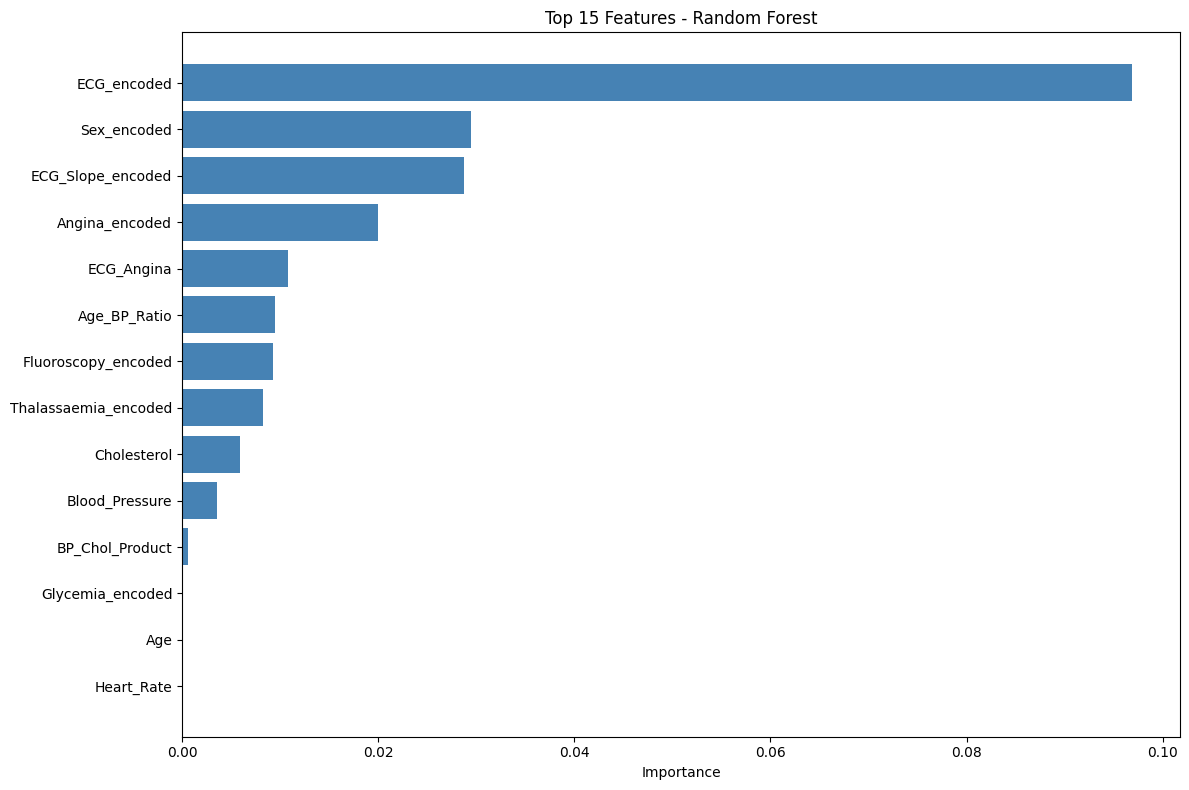

In [104]:
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(top_features['Feature'], top_features['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title('Top 15 Features - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("feature_importance_rf.png", dpi=300, bbox_inches='tight')
plt.show()

Matrice de confusion

In [105]:
rf_predictions.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   25|
|  0.0|       1.0|    5|
|  1.0|       0.0|    8|
|  0.0|       0.0|   41|
+-----+----------+-----+



## Le modele qui a donner des meilleurs resultats est celui de la Regression logistique avec un F1 score qui est ~ 87%

Tableau comparatif:
             Modèle  Accuracy  F1-Score  Precision   Recall
Logistic Regression  0.873418  0.870964   0.879476 0.873418
      Random Forest  0.835443  0.834123   0.835314 0.835443


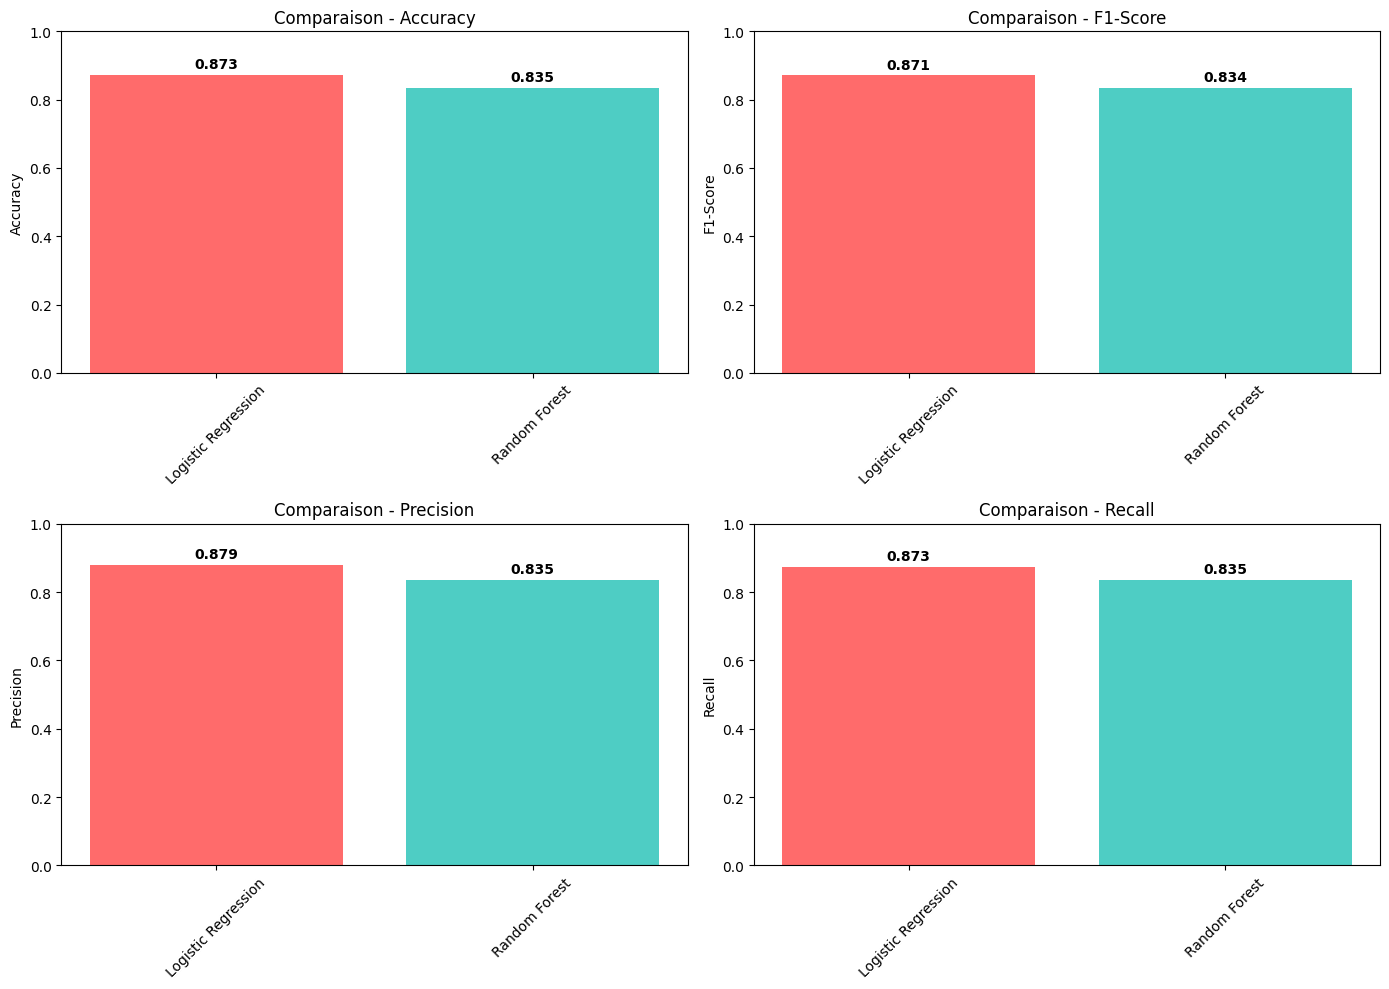

MEILLEUR MODÈLE: Logistic Regression
   F1-Score: 0.8710


In [108]:

# # Créer un DataFrame comparatif
# comparison_df = pd.DataFrame({
#     'Modèle': ['Logistic Regression', 'Random Forest'],
#     'Accuracy': [lr_accuracy, rf_accuracy],
#     'F1-Score': [lr_f1, rf_f1],
#     'Precision': [lr_precision, rf_precision],
#     'Recall': [lr_recall, rf_recall]
# })

# print("Tableau comparatif:")
# print(comparison_df.to_string(index=False))

# # Visualisation comparative
# fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# metrics = ['Accuracy', 'F1-Score', 'Precision', 'Recall']
# colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

# for idx, metric in enumerate(metrics):
#     ax = axes[idx // 2, idx % 2]
#     ax.bar(comparison_df['Modèle'], comparison_df[metric], color=colors)
#     ax.set_ylabel(metric)
#     ax.set_title(f'Comparaison - {metric}')
#     ax.set_ylim([0, 1])
#     ax.tick_params(axis='x', rotation=45)

#     # Ajouter les valeurs sur les barres
#     for i, v in enumerate(comparison_df[metric]):
#         ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# plt.tight_layout()
# plt.savefig("models_comparison.png", dpi=300, bbox_inches='tight')
# plt.show()

# # Identifier le meilleur modèle
# best_model_idx = comparison_df['F1-Score'].idxmax()
# best_model_name = comparison_df.loc[best_model_idx, 'Modèle']
# print(f"MEILLEUR MODÈLE: {best_model_name}")
# print(f"   F1-Score: {comparison_df.loc[best_model_idx, 'F1-Score']:.4f}")


Tableau comparatif des modèles :
                Modèle  Accuracy  F1-Score  Precision    Recall
0  Logistic Regression  0.873418  0.870964   0.879476  0.873418
1        Random Forest  0.835443  0.834123   0.835314  0.835443


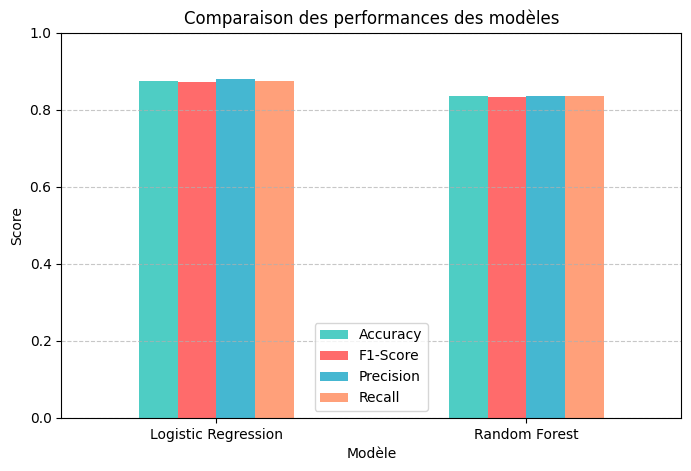

 Meilleur modèle : Logistic Regression avec F1-Score = 0.871


In [110]:
data = {
    'Modèle': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'F1-Score': [lr_f1, rf_f1],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall]
}

df_compare = pd.DataFrame(data)
print("Tableau comparatif des modèles :")
print(df_compare)

df_compare.set_index('Modèle')[['Accuracy', 'F1-Score', 'Precision', 'Recall']].plot(
    kind='bar', figsize=(8,5), color=['#4ECDC4', '#FF6B6B', '#45B7D1', '#FFA07A']
)

plt.title('Comparaison des performances des modèles')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

best_model = df_compare.loc[df_compare['F1-Score'].idxmax()]
print(f" Meilleur modèle : {best_model['Modèle']} avec F1-Score = {best_model['F1-Score']:.3f}")

# Sauvegarde du modèle

In [111]:
model_path = "./best_cardiovascular_model"
lr_model.write().overwrite().save(model_path)
print(f"Modèle sauvegardé dans: {model_path}")

Modèle sauvegardé dans: ./best_cardiovascular_model


# PRÉDICTION SUR NOUVELLES DONNÉES

In [116]:
new_patients = [
    (55, 1, 3, 145, 240, 1, 0, 150, 1, 1.5, 1, 1, 3),  # Patient 1
    (42, 0, 1, 120, 180, 0, 0, 165, 0, 0.0, 2, 0, 2),  # Patient 2
    (68, 1, 4, 160, 310, 1, 1, 110, 1, 3.5, 0, 2, 3),  # Patient 3
]
columns = ["Age", "Sex", "Angina", "Blood_Pressure", "Cholesterol",
           "Glycemia", "ECG", "Heart_Rate", "Angina_After_Sport",
           "ECG_Angina", "ECG_Slope", "Fluoroscopy", "Thalassaemia"]
new_df = spark.createDataFrame(new_patients,columns)

# Recode categorical values in new_df to match the format used during training
new_df = new_df.withColumn("Sex",when(col("Sex")==0,"Female").otherwise("Male"))
new_df = new_df.withColumn("Glycemia", when(col("Glycemia")==0,"<=120").otherwise(">120"))
new_df = new_df.withColumn("Angina_After_Sport",when(col("Angina_After_Sport")==0,"No").otherwise("Yes"))
new_df = new_df.withColumn("Angina",when(col("Angina")==1,"Stable Angina").when(col("Angina")==2,"Unstable angina").when(col("Angina")==3,"Other pains").otherwise("Asymptomatic"))
new_df = new_df.withColumn("ECG",when(col("ECG")==0,"Normal").when(col("ECG")=="1","Anomalies").otherwise("Hypertrophy"))
new_df = new_df.withColumn("ECG_Slope",when(col("ECG_Slope")==1,"Rising").when(col("ECG_Slope")=="2","Stable").otherwise("Falling"))
new_df = new_df.withColumn("Fluoroscopy",when(col("Fluoroscopy")==0,"No anomaly").when(col("Fluoroscopy")==1,"Low").when(col("Fluoroscopy")==2,"Medium").otherwise("High"))
new_df = new_df.withColumn("Thalassaemia",when(col("Thalassaemia")==3,"No").when(col("Thalassaemia")=="6","Thalassemia under control").otherwise("Unstable Thalassaemia"))


print("Nouveaux patients à prédire:")
new_df.show()

# Add the engineered features to new_df to match the training data structure
new_df = new_df.withColumn("Age_BP_Ratio", col("Age") / col("Blood_Pressure"))
new_df = new_df.withColumn("BP_Chol_Product", col("Blood_Pressure") * col("Cholesterol") / 10000)


# Make predictions using the trained pipeline model
predictions_new = lr_model.transform(new_df)

print("Résultats des prédictions:")
predictions_new.select("Age", "Sex", "Blood_Pressure", "Cholesterol",
                       "prediction", "probability").show(truncate=False)

# Interpret the results
print("\Interprétation:")
# Collect the predictions to iterate and print
predictions_collected = predictions_new.collect()

for i, row in enumerate(predictions_collected, 1):
    risk = "ÉLEVÉ ⚠️" if row.prediction == 1 else "FAIBLE ✅"
    # Ensure probability is accessed correctly based on the vector structure
    prob = row.probability[1] * 100 if row.probability else 0.0
    print(f"   Patient {i}: Risque {risk} (probabilité: {prob:.1f}%)")

<>:38: SyntaxWarning: invalid escape sequence '\I'
<>:38: SyntaxWarning: invalid escape sequence '\I'
/tmp/ipython-input-1849429586.py:38: SyntaxWarning: invalid escape sequence '\I'
  print("\Interprétation:")


Nouveaux patients à prédire:
+---+------+-------------+--------------+-----------+--------+---------+----------+------------------+----------+---------+-----------+--------------------+
|Age|   Sex|       Angina|Blood_Pressure|Cholesterol|Glycemia|      ECG|Heart_Rate|Angina_After_Sport|ECG_Angina|ECG_Slope|Fluoroscopy|        Thalassaemia|
+---+------+-------------+--------------+-----------+--------+---------+----------+------------------+----------+---------+-----------+--------------------+
| 55|  Male|  Other pains|           145|        240|    >120|   Normal|       150|               Yes|       1.5|   Rising|        Low|                  No|
| 42|Female|Stable Angina|           120|        180|   <=120|   Normal|       165|                No|       0.0|   Stable| No anomaly|Unstable Thalassa...|
| 68|  Male| Asymptomatic|           160|        310|    >120|Anomalies|       110|               Yes|       3.5|  Falling|     Medium|                  No|
+---+------+-------------+---

# Arrêter la session Spark


In [117]:
spark.stop()

In [118]:
print("PIPLINE SPARKML TERMINE AVEC SUCCES!")

PIPLINE SPARKML TERMINE AVEC SUCCES!
